In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import os
import shutil
import subprocess
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import h2o
from h2o.estimators.word2vec import H2OWord2vecEstimator

In [2]:
project_name = 'dropwizard'
version_name = 'v2.0.6'

n_cluster_divisible_arr = [5,7,10,15,20,25]
affinity_arr = ['euclidean', 'manhattan', 'cosine']
linkage_arr = ['complete', 'average', 'single']

n_cluster = 300
affinity = 'cosine'
linkage = 'single'

In [7]:
depends_dir = f'C:/Users/tanji/Desktop/SoftwareRemodularization/raw_depends/{project_name}/{project_name}_{version_name}.json'
rootdir = f'C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/{project_name}/{project_name}_{version_name}'

In [8]:
print(rootdir)

C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/dropwizard/dropwizard_v2.0.6


In [9]:
full_dir_arr = []
for root, dirs, files in os.walk(rootdir):
    #print(root)
    #print(dirs)
    for element in files:
        if '.java' in element:
            dir_string = root + '\\' + element
            full_dir_arr.append(dir_string)

cluster_dict = {}
cluster_tree = {}


for element in full_dir_arr:
    element = element.split('\\')
    child = element[-1]
    parent = element[-2]
    cluster_tree[child] = parent

In [10]:
cluster_tree

{'MavenWrapperDownloader.java': 'wrapper',
 '__name__Application.java': 'java',
 '__name__Configuration.java': 'java',
 'AssetsBundle.java': 'assets',
 'AssetsBundleTest.java': 'assets',
 'Auth.java': 'auth',
 'AuthDynamicFeature.java': 'auth',
 'AuthenticationException.java': 'auth',
 'Authenticator.java': 'auth',
 'AuthFilter.java': 'auth',
 'AuthorizationContext.java': 'auth',
 'Authorizer.java': 'auth',
 'AuthValueFactoryProvider.java': 'auth',
 'CachingAuthenticator.java': 'auth',
 'CachingAuthorizer.java': 'auth',
 'DefaultUnauthorizedHandler.java': 'auth',
 'JSONUnauthorizedHandler.java': 'auth',
 'OptionalPrincipalContainerRequestValueFactory.java': 'auth',
 'PermitAllAuthorizer.java': 'auth',
 'PolymorphicAuthDynamicFeature.java': 'auth',
 'PolymorphicAuthValueFactoryProvider.java': 'auth',
 'PrincipalContainerRequestValueFactory.java': 'auth',
 'PrincipalImpl.java': 'auth',
 'UnauthorizedHandler.java': 'auth',
 'WebApplicationExceptionCatchingFilter.java': 'auth',
 'BasicCred

In [11]:
len(cluster_tree)

815

In [8]:
try:
    os.mkdir('raw_depends/' + project_name)
except:
    pass

command = 'cd C:/Users/tanji/Desktop/SoftwareRemodularization/depends-0.9.2 & ' + f"java -jar depends.jar java C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/{project_name}/{project_name}_{version_name}" +  f' ../raw_depends/{project_name}/{project_name}_{version_name}' 
print(command)
os.system(command)

cd C:/Users/tanji/Desktop/SoftwareRemodularization/depends-0.9.2 & java -jar depends.jar java C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/dropwizard/dropwizard_v2.0.6 ../raw_depends/dropwizard/dropwizard_v2.0.6


0

In [12]:
with open(depends_dir) as f:
    depends_results = json.load(f)
    index  = 0
    var_array = []
    print(len(depends_results['variables']))
    for value in depends_results['variables']:
        var_array.append([index, value.split('\\')[-1]])
        #print(index, value)
        index += 1

847


In [13]:
with open(depends_dir) as f:
    depends_results = json.load(f)
    index  = 0
    var_array = []
    print(len(depends_results['variables']))
    print(len(depends_results['cells']))
    for value in depends_results['variables']:
        var_array.append([index, value.split('\\')[-1]])
        #print(index, value)
        index += 1

    var_df = pd.DataFrame(var_array)
    var_df.columns = ['index_val', 'name']

    feature_list = {}
    feature_index = 2
    for element in depends_results['cells']:
        #print(element)
        try:
            for a in element['values']:
                if a not in feature_list:
                    feature_list[a] = feature_index
                    feature_index += 1
                #print(a['Call'])


        except:
            pass

    feature_arr = []
    for element in depends_results['cells']:
        #print(array)
        array = [0] * (len(feature_list) + 2)
        values = dict(element['values'])
        #print(element)
        array[0] = element['src']
        array[1] = element['dest']
        for feature in feature_list:
            try:
                value = values[feature]
                array[feature_list[feature]] = value
            except:
                pass
        #print(array)
        feature_arr.append(array)

    feature_df = pd.DataFrame(feature_arr)
    col_names = ['src', 'dest']
    for element in feature_list:
        col_names.append(element)
    feature_df.columns = col_names

    feature_df['sum'] = feature_df.sum(axis=1) - feature_df['src'] - feature_df['dest']
    #G = nx.Graph()
    G = nx.path_graph(len(depends_results['variables']))
    for index, row in feature_df.iterrows():
        G.add_edge(row['src'], row['dest'], weight=row['sum'])

    adj_mat = nx.adjacency_matrix(G)
    adj_mat_df = pd.DataFrame(adj_mat.toarray())
    np.fill_diagonal(adj_mat_df.values, adj_mat_df.values.max())
    x = adj_mat_df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    adj_mat_df = pd.DataFrame(x_scaled)
    
    sum_dependency_df = nx.to_pandas_adjacency(G)
    sum_dependency_df['sum'] = sum_dependency_df.sum(axis=1)
    final_dependency_df = sum_dependency_df['sum']

847
2622


In [14]:
final_dependency_df

0       1.0
1       2.0
2       2.0
3      31.0
4      58.0
       ... 
842    23.0
843    41.0
844    29.0
845    42.0
846     5.0
Name: sum, Length: 847, dtype: float64

In [15]:
adj_mat_df

,0,1,2,3,4,5,6,7,8,9,...,837,838,839,840,841,842,843,844,845,846
0,1.000000,0.000787,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000787,1.000000,0.000787,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000787,1.000000,0.000787,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000787,1.000000,0.011802,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.011802,1.000000,0.000787,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000787,1.000000,0.000787,0.000000,0.000000,0.000000
843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.001574,0.004721,0.0,0.004721,0.000000,0.000787,1.000000,0.003934,0.006294,0.000000
844,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.001574,0.004721,0.0,0.004721,0.000000,0.000000,0.003934,1.000000,0.000787,0.000000
845,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.001574,0.000000,0.0,0.020456,0.003147,0.000000,0.006294,0.000787,1.000000,0.000787


In [16]:
feature_df

,src,dest,Call,Create,Contain,Use,Import,Parameter,Annotation,Extend,Return,Implement,Cast,Throw,sum
0,834,829,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,389,303,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2,591,579,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,127,312,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,682,681,2.0,0.0,2.0,2.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2617,569,779,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2618,519,512,24.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
2619,530,747,6.0,0.0,3.0,4.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,20.0
2620,519,513,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [14]:
print('Currently processing: ' + project_name + version_name)
command = f'java -jar ck-0.3.3-SNAPSHOT-jar-with-dependencies.jar raw_sourcecode/{project_name}/{project_name}_{version_name}'
print(command)
os.system(command)
os.rename('class.csv', project_name + '_' + version_name + '_class.csv')
os.rename('field.csv',  project_name + '_' + version_name + '_field.csv')
os.rename('method.csv', project_name + '_' + version_name + '_method.csv')

shutil.move(project_name + '_' + version_name + '_class.csv', 'ck_results_invi/' + project_name + '_' + version_name + '_class.csv')
shutil.move(project_name + '_' + version_name + '_field.csv', 'ck_results_invi/' + project_name + '_' + version_name + '_field.csv')
shutil.move(project_name + '_' + version_name + '_method.csv', 'ck_results_invi/' + project_name + '_' + version_name + '_method.csv')

          

Currently processing: dropwizardv2.0.6
java -jar ck-0.3.3-SNAPSHOT-jar-with-dependencies.jar raw_sourcecode/dropwizard/dropwizard_v2.0.6


'ck_results_invi/dropwizard_v2.0.6_method.csv'

In [17]:
cluster = AgglomerativeClustering(n_clusters=n_cluster, affinity=affinity, linkage=linkage)
cluster_result = cluster.fit_predict(adj_mat_df)

ck_metrics = pd.read_csv(f'ck_results_invi/{project_name}_{version_name}_class.csv')
ck_metrics['class_name'] = ck_metrics['file'].str.split('\\').str[-1]
filename_a = 'C:/Users/tanji/Desktop/SoftwareRemodularization/MoJo_1.2.1/' + project_name + '/' + project_name + '_' + version_name + '_' + str(n_cluster) + '_' +str(affinity) + '_' + str(linkage) + '_a.rsf'
filename_b = 'C:/Users/tanji/Desktop/SoftwareRemodularization/MoJo_1.2.1/' + project_name + '/' + project_name + '_' + version_name + '_' + str(n_cluster) + '_' +str(affinity) + '_' + str(linkage) + '_b.rsf'

with open(filename_a, 'w') as f:
    for key, value in cluster_tree.items():
        f.write('contain ' + str(value).replace(" ",'') + ' ' + str(key).replace(' ','') + '\n')

arr_a_rsf = []
arr_b_rsf = []
with open(filename_b, 'w') as f:
    len_b_rsf = 0
    duplicate_array = []
    refactor_arr_pretty_print = []
    refactor_arr = []
    main_data_arr = []
    clustering_result_dict = {}
    num_line_affected = 0
    num_dependency = 0
    actual_num_of_classes_touched = 0
    for i in range(len(cluster_result)):
        #print(i)
        try:
            subject = var_df[var_df['index_val'] == i]['name'].values[0]
            #print(subject)
            #print(subject in cluster_tree)
            if subject in cluster_tree and subject not in duplicate_array:
                #print(element)
                duplicate_array.append(subject)
                string = "contain " + str(cluster_result[i]) + " " + subject + "\n"
                arr_b_rsf.append(subject)
                len_b_rsf += 1
                f.write(string)
                #print(subject)
                class_metrics = ck_metrics.loc[ck_metrics['class_name'] == subject].values.tolist()[0]
                
                #print(ck_metrics.loc[ck_metrics['class_name'] == subject]['file'].values[0])
                
                subjected_file = ck_metrics.loc[ck_metrics['class_name'] == subject]['file'].values[0]
                
                #print(subjected_file)
                
                num_dependency = final_dependency_df.iloc[cluster_result[i]]
                num_line_affected += sum(1 for line in open(subjected_file))
                
                
                class_metrics.append(num_dependency)
                class_metrics.append(num_line_affected)
                main_data_arr.append(class_metrics)
                
                
                ## Important
                ## This is assuming that during Depends, the file structure is already sorted
                ## I.e. going through the directory structure depth wise, not breath wise
                original_parent = cluster_tree[subject]
                try:
                    to_check_parent = clustering_result_dict[cluster_result[i]]
                    #print(original_parent, to_check_parent)
                    if original_parent != to_check_parent:
                        #print(i)
                        #refactor_arr.append(f'Move {subject} to {str(i)}')
                        #refactor_arr.append(f'Move {subject} to {str(cluster_result[i])}')
                        temp_arr = []
                        temp_arr.append(subject)
                        temp_arr.append(cluster_result[i-1])
                        refactor_arr.append(temp_arr)
                        refactor_arr_pretty_print.append(f'Move {subject} to {str(cluster_result[i-1])}')
                        actual_num_of_classes_touched += 1
                    
                    clustering_result_dict[cluster_result[i]] = to_check_parent
                except:
                    clustering_result_dict[cluster_result[i]] = original_parent
                
            else:
                #print(subject)
                pass
        except Exception as e:
            #print(e)
            pass
f.close()

command = 'cd C:/Users/tanji/Desktop/SoftwareRemodularization/MoJo_1.2.1 & ' + 'java MoJo ' + filename_a + ' ' + filename_b + ' >> ' + project_name + '/' + project_name + '_results.txt'
#print(command)
os.system(command)

0

In [18]:
cluster_result

array([223, 287, 215,   0,   0, 239, 185,   0, 184,   0,   0,   0,   0,
         0,   0, 294,   0, 285,   0, 168, 166, 289,   0,   0, 227,   0,
         0,   0,   0,   0,   0,   0, 183,   0,   0, 267,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 199,   0,   0, 186,   0,   0,   6,
         0,   0, 242, 217, 243,   0,   0,   0,   0,   0,   0,   0,   0,
        91,   0,  29,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        29,   0,   0,   0,   0,   0,   0,   0,   0, 290,  49,  55,   0,
         0,   0,   0, 238, 261,   0,   0,   0,   0,  49,  55, 231,   0,
         0, 273,   0, 218,   0,   0,   0,   0, 209,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 191,   0,
         0, 288,   0,   0, 265, 297, 299, 195, 224, 233, 211, 228, 221,
       255, 201, 207,   0,   0,   0,   0,   0,   0,   0,   0,   

In [19]:
print(len(refactor_arr_pretty_print))
refactor_arr_pretty_print

489


['Move AuthFilter.java to 185',
 'Move AuthenticationException.java to 184',
 'Move Authenticator.java to 0',
 'Move AuthorizationContext.java to 0',
 'Move Authorizer.java to 0',
 'Move CachingAuthenticator.java to 0',
 'Move CachingAuthorizer.java to 0',
 'Move JSONUnauthorizedHandler.java to 294',
 'Move PermitAllAuthorizer.java to 285',
 'Move PrincipalImpl.java to 289',
 'Move UnauthorizedHandler.java to 0',
 'Move BasicCredentialAuthFilter.java to 227',
 'Move BasicCredentials.java to 0',
 'Move ChainedAuthFilter.java to 0',
 'Move OAuthCredentialAuthFilter.java to 0',
 'Move AbstractAuthResourceConfig.java to 0',
 'Move AuthBaseTest.java to 0',
 'Move AuthFilterTest.java to 0',
 'Move CachingAuthenticatorTest.java to 183',
 'Move CachingAuthorizerTest.java to 0',
 'Move BasicAuthProviderTest.java to 267',
 'Move BasicCredentialsTest.java to 0',
 'Move BasicCustomAuthProviderTest.java to 0',
 'Move ChainedAuthProviderTest.java to 0',
 'Move OAuthCustomProviderTest.java to 0',
 'M

In [20]:
refactor_arr

[['AuthFilter.java', 185],
 ['AuthenticationException.java', 184],
 ['Authenticator.java', 0],
 ['AuthorizationContext.java', 0],
 ['Authorizer.java', 0],
 ['CachingAuthenticator.java', 0],
 ['CachingAuthorizer.java', 0],
 ['JSONUnauthorizedHandler.java', 294],
 ['PermitAllAuthorizer.java', 285],
 ['PrincipalImpl.java', 289],
 ['UnauthorizedHandler.java', 0],
 ['BasicCredentialAuthFilter.java', 227],
 ['BasicCredentials.java', 0],
 ['ChainedAuthFilter.java', 0],
 ['OAuthCredentialAuthFilter.java', 0],
 ['AbstractAuthResourceConfig.java', 0],
 ['AuthBaseTest.java', 0],
 ['AuthFilterTest.java', 0],
 ['CachingAuthenticatorTest.java', 183],
 ['CachingAuthorizerTest.java', 0],
 ['BasicAuthProviderTest.java', 267],
 ['BasicCredentialsTest.java', 0],
 ['BasicCustomAuthProviderTest.java', 0],
 ['ChainedAuthProviderTest.java', 0],
 ['OAuthCustomProviderTest.java', 0],
 ['OAuthProviderTest.java', 0],
 ['JsonPrincipal.java', 0],
 ['NoAuthPolymorphicPrincipalEntityResource.java', 0],
 ['NoAuthPoly

In [21]:
refactor_df = pd.DataFrame(refactor_arr)
refactor_df.columns = ['class_name', 'refactor_destination']
refactor_df.head()

,class_name,refactor_destination
0,AuthFilter.java,185
1,AuthenticationException.java,184
2,Authenticator.java,0
3,AuthorizationContext.java,0
4,Authorizer.java,0


In [85]:
temp_dataframe = pd.DataFrame(main_data_arr)
temp_columns = list(ck_metrics.columns)
temp_columns.append('num_dependency')
temp_columns.append('num_line_affected')
temp_dataframe.columns = temp_columns

## For the groupby operation below
#temp_dataframe['placeholder_key'] = 'placeholder_key'

In [86]:
temp_dataframe.head()

,file,class,type,cbo,wmc,dit,rfc,lcom,totalMethods,staticMethods,...,variablesQty,maxNestedBlocks,anonymousClassesQty,subClassesQty,lambdasQty,uniqueWordsQty,modifiers,class_name,num_dependency,num_line_affected
0,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,MavenWrapperDownloader,class,1,9,1,17,1,2,2,...,13,4,0,0,0,82,1,MavenWrapperDownloader.java,37.0,110
1,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,$.$,class,2,7,1,0,6,4,1,...,2,0,0,0,0,12,1,__name__Application.java,8.0,139
2,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.assets.AssetsBundle,class,7,14,1,9,0,10,0,...,8,1,0,0,0,92,1,AssetsBundle.java,1.0,266
3,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.assets.AssetsBundleTest,class,12,9,1,25,4,9,0,...,7,0,0,0,0,51,1,AssetsBundleTest.java,1.0,423
4,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.auth.AuthDynamicFeature,class,11,13,1,9,0,4,0,...,8,4,0,0,0,84,1,AuthDynamicFeature.java,19.0,516


In [87]:
temp_dataframe = pd.merge(refactor_df, temp_dataframe, on='class_name', how='left')

In [88]:
temp_dataframe.head()

,class_name,refactor_destination,file,class,type,cbo,wmc,dit,rfc,lcom,...,mathOperationsQty,variablesQty,maxNestedBlocks,anonymousClassesQty,subClassesQty,lambdasQty,uniqueWordsQty,modifiers,num_dependency,num_line_affected
0,AuthFilter.java,185,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.auth.AuthFilter,class,15,4,1,9,0,...,0,10,2,1,1,2,96,1025,1.0,690
1,AuthenticationException.java,184,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.auth.AuthenticationException,class,0,3,3,0,3,...,0,1,0,0,0,0,37,1,1.0,802
2,Authenticator.java,0,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.auth.Authenticator,interface,2,1,1,0,0,...,0,0,-1,0,0,0,41,1,1.0,829
3,AuthorizationContext.java,0,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.auth.AuthorizationContext,class,4,9,1,3,0,...,0,4,0,0,0,0,21,0,1.0,876
4,Authorizer.java,0,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,io.dropwizard.auth.Authorizer,interface,4,2,1,1,1,...,0,0,0,0,0,0,30,1,1.0,913


In [89]:
project_refactoring_data_agg = temp_dataframe.groupby(['class_name'], as_index=False).agg({
       'cbo': ['mean', 'min', 'max','std'], 
        'wmc': ['mean', 'min', 'max','std'], 
        'dit': ['mean', 'min', 'max','std'], 
        'rfc': ['mean', 'min', 'max','std'], 
        'lcom': ['mean', 'min', 'max','std'],
        'totalMethods': ['mean', 'min', 'max','std'], 
        'staticMethods': ['mean', 'min', 'max','std'],
        'publicMethods': ['mean', 'min', 'max','std'], 
        'privateMethods': ['mean', 'min', 'max','std'],
        'protectedMethods': ['mean', 'min', 'max','std'], 
        'defaultMethods': ['mean', 'min', 'max','std'], 
        'abstractMethods': ['mean', 'min', 'max','std'], 
        'finalMethods': ['mean', 'min', 'max','std'],
        'synchronizedMethods': ['mean', 'min', 'max','std'],
        'totalFields': ['mean', 'min', 'max','std'], 
        'staticFields': ['mean', 'min', 'max','std'], 
        'publicFields': ['mean', 'min', 'max','std'],
        'privateFields': ['mean', 'min', 'max','std'],
        'protectedFields': ['mean', 'min', 'max','std'],
        'defaultFields': ['mean', 'min', 'max','std'], 
        'finalFields': ['mean', 'min', 'max','std'],
        'synchronizedFields': ['mean', 'min', 'max','std'],
        'nosi': ['mean', 'min', 'max','std'], 
        'loc': ['mean', 'min', 'max','std'], 
        'returnQty': ['mean', 'min', 'max','std'],
        'loopQty': ['mean', 'min', 'max','std'],
        'comparisonsQty': ['mean', 'min', 'max','std'],
        'tryCatchQty': ['mean', 'min', 'max','std'],
        'parenthesizedExpsQty': ['mean', 'min', 'max','std'],
        'stringLiteralsQty': ['mean', 'min', 'max','std'],
        'numbersQty': ['mean', 'min', 'max','std'], 
        'assignmentsQty': ['mean', 'min', 'max','std'],
        'mathOperationsQty': ['mean', 'min', 'max','std'], 
        'variablesQty': ['mean', 'min', 'max','std'], 
        'maxNestedBlocks': ['mean', 'min', 'max','std'],
        'anonymousClassesQty': ['mean', 'min', 'max','std'],
        'subClassesQty': ['mean', 'min', 'max','std'],
        'lambdasQty': ['mean', 'min', 'max','std'],
        'uniqueWordsQty': ['mean', 'min', 'max','std'],
        'modifiers': ['mean', 'min', 'max','std'],
        'num_dependency': ['mean'],
        'num_line_affected': ['mean'],
})

In [90]:
project_refactoring_data_agg

class_name  cbo              wmc              dit  \
                                       mean min max std mean min max std mean   
0         AbstractAppenderFactory.java   31  31  31 NaN   28  28  28 NaN    1   
1      AbstractAuthResourceConfig.java    8   8   8 NaN    5   5   5 NaN    3   
2                     AbstractDAO.java   12  12  12 NaN   17  17  17 NaN    1   
3                 AbstractDAOTest.java   19  19  19 NaN   17  17  17 NaN    2   
4               AbstractHttp2Test.java   12  12  12 NaN    6   6   6 NaN    1   
..                                 ...  ...  ..  ..  ..  ...  ..  ..  ..  ...   
484            ViolationCollector.java    6   6   6 NaN   18  18  18 NaN    1   
485         WrappedFailingExample.java    4   4   4 NaN    2   2   2 NaN    1   
486    WrappedValidRepresentation.java    4   4   4 NaN    2   2   2 NaN    1   
487      YamlConfigurationFactory.java    6   6   6 NaN    1   1   1 NaN    2   
488  YamlConfigurationFactoryTest.java    5   5   5 NaN    3   3   3 NaN    2   

     ... uniqueWordsQty               modifiers                  \
     ...           mean  min  max std      mean   min   max std   
0    ...            140  140  140 NaN      1025  1025  1025 NaN   
1    ...             30   30   30 NaN      1025  1025  1025 NaN   
2    ...            132  132  132 NaN         1     1     1 NaN   
3    ...             74   74   74 NaN         1     1     1 NaN   
4    ...             49   49   49 NaN         1     1     1 NaN   
..   ...            ...  ...  ...  ..       ...   ...   ...  ..   
484  ...             95   95   95 NaN         1     1     1 NaN   
485  ...              6    6    6 NaN         1     1     1 NaN   
486  ...              6    6    6 NaN         1     1     1 NaN   
487  ...             45   45   45 NaN         1     1     1 NaN   
488  ...             46   46   46 NaN         1     1     1 NaN   

    num_dependency num_line_affected  
              mean              mean  
0              1.0             44006  
1              1.0              1937  
2              1.0             20483  
3              1.0             21564  
4              1.0             23834  
..             ...               ...  
484            1.0             66497  
485            1.0             35758  
486            1.0             35781  
487            1.0             10442  
488            1.0             11385  

[489 rows x 163 columns]

In [91]:
columns_to_agg = [
    'cbo', 'wmc', 'dit', 'rfc', 'lcom',
       'totalMethods', 'staticMethods', 'publicMethods', 'privateMethods',
       'protectedMethods', 'defaultMethods', 'abstractMethods', 'finalMethods',
       'synchronizedMethods', 'totalFields', 'staticFields', 'publicFields',
       'privateFields', 'protectedFields', 'defaultFields', 'finalFields',
       'synchronizedFields', 'nosi', 'loc', 'returnQty', 'loopQty',
       'comparisonsQty', 'tryCatchQty', 'parenthesizedExpsQty',
       'stringLiteralsQty', 'numbersQty', 'assignmentsQty',
       'mathOperationsQty', 'variablesQty', 'maxNestedBlocks',
       'anonymousClassesQty', 'subClassesQty', 'lambdasQty', 'uniqueWordsQty',
       'modifiers'
]


project_refactoring_data_agg_column_names = ['class_name']
for element in columns_to_agg:
    project_refactoring_data_agg_column_names.append(element + '_mean')
    project_refactoring_data_agg_column_names.append(element + '_min')
    project_refactoring_data_agg_column_names.append(element + '_max')
    project_refactoring_data_agg_column_names.append(element + '_std')
    
    
project_refactoring_data_agg_column_names.append('num_dependency_mean')
project_refactoring_data_agg_column_names.append('num_line_affected_mean')

In [92]:
project_refactoring_data_agg.columns = project_refactoring_data_agg_column_names

In [93]:
project_refactoring_data_agg['refactor_destination'] = temp_dataframe['refactor_destination']
project_refactoring_data_agg['file'] = temp_dataframe['file']
project_refactoring_data_agg = project_refactoring_data_agg.replace(to_replace= r'C:\\Users\\tanji\\Desktop\\SoftwareRemodularization\\raw_sourcecode', value= '', regex=True)
project_refactoring_data_agg = project_refactoring_data_agg.replace(to_replace= r'\\', value= ' ', regex=True)
project_refactoring_data_agg['file'] = project_refactoring_data_agg['file'].replace(to_replace= r'.java', value= '', regex=True)


In [94]:
project_refactoring_data_agg

,class_name,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,...,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactor_destination,file
0,AbstractAppenderFactory.java,31,31,31,NaN,28,28,28,NaN,1,...,140,NaN,1025,1025,1025,NaN,1.0,44006,185,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
1,AbstractAuthResourceConfig.java,8,8,8,NaN,5,5,5,NaN,3,...,30,NaN,1025,1025,1025,NaN,1.0,1937,184,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
2,AbstractDAO.java,12,12,12,NaN,17,17,17,NaN,1,...,132,NaN,1,1,1,NaN,1.0,20483,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
3,AbstractDAOTest.java,19,19,19,NaN,17,17,17,NaN,2,...,74,NaN,1,1,1,NaN,1.0,21564,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
4,AbstractHttp2Test.java,12,12,12,NaN,6,6,6,NaN,1,...,49,NaN,1,1,1,NaN,1.0,23834,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,ViolationCollector.java,6,6,6,NaN,18,18,18,NaN,1,...,95,NaN,1,1,1,NaN,1.0,66497,0,dropwizard dropwizard_v2.0.6 dropwizard-views...
485,WrappedFailingExample.java,4,4,4,NaN,2,2,2,NaN,1,...,6,NaN,1,1,1,NaN,1.0,35758,0,dropwizard dropwizard_v2.0.6 dropwizard-views...
486,WrappedValidRepresentation.java,4,4,4,NaN,2,2,2,NaN,1,...,6,NaN,1,1,1,NaN,1.0,35781,0,dropwizard dropwizard_v2.0.6 dropwizard-views...
487,YamlConfigurationFactory.java,6,6,6,NaN,1,1,1,NaN,2,...,45,NaN,1,1,1,NaN,1.0,10442,0,dropwizard dropwizard_v2.0.6 dropwizard-views...


In [95]:
project_refactoring_data_agg = project_refactoring_data_agg.fillna(0)

In [96]:
project_refactoring_data_agg[project_refactoring_data_agg['class_name']== 'AuthFilter.java']

,class_name,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,...,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactor_destination,file
35,AuthFilter.java,15,15,15,0.0,4,4,4,0.0,1,...,96,0.0,1025,1025,1025,0.0,1.0,690,243,dropwizard dropwizard_v2.0.6 dropwizard-clien...


In [116]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,23 mins 46 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,7 months and 9 days !!!
H2O_cluster_name:,H2O_from_python_tanji_lj2wno
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.984 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [119]:
def create_token_table(data_hdf, col_name, prefix, sent_sample_rate = 0.0, epochs = 25, vec_size=20):
    # Tokenize
    words = tokenize(data_hdf[col_name])
    w2v_model = H2OWord2vecEstimator(sent_sample_rate = sent_sample_rate, 
                                     epochs = epochs, 
                                     vec_size = vec_size)
    w2v_model.train(training_frame=words)
    
    # Create the training vectors
    vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")
    
    
    # Prefix naming the columns
    vecs.columns = ['%s%s' % (prefix, c) for c in vecs.columns]
    data2_hdf = data_hdf.cbind(vecs)
    return data2_hdf, w2v_model

    
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [131]:
commit_message_df = project_refactoring_data_agg[['file',]]
#commit_message_df = commit_message_df['file'].str.split(' ')
commit_message_df['file'] = commit_message_df['file'].apply(lambda x: x.split()[-2:])
commit_message_df['file'] = commit_message_df['file'].apply(lambda x: ' '.join(x))
commit_message_df.shape
commit_message_df.head()
commit_message_hdf = h2o.H2OFrame(commit_message_df, 
                         column_types = {'file': 'string'}
                        )
commit_message_hdf.types

C:\Users\tanji\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\tanji\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Parse progress: |█████████████████████████████████████████████████████████| 100%


{'file': 'string'}

In [132]:
commit_message_hdf.head()

file
auth AuthFilter
auth AuthenticationException
auth Authenticator
auth AuthorizationContext
auth Authorizer
auth CachingAuthenticator
auth CachingAuthorizer
auth JSONUnauthorizedHandler
auth PermitAllAuthorizer
auth PrincipalImpl


In [133]:
STOP_WORDS = ['C:', 'Users', 'tanji', 'Desktop', 'Software', 'Remodularization']
commit_message_vecs_hdf, commit_message_w2v_model = create_token_table(commit_message_hdf,
                                                                  'file',
                                                                   prefix='file_',
                                                                   vec_size=15)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


In [134]:
commit_message_vecs_hdf.tail()

file,file_C1,file_C2,file_C3,file_C4,file_C5,file_C6,file_C7,file_C8,file_C9,file_C10,file_C11,file_C12,file_C13,file_C14,file_C15
mustache MustacheViewRendererFileSystemTest,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mustache MustacheViewRendererTest,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
views View,0.0200166,-0.0126389,-0.0318414,-0.0214365,-0.0234041,-0.015869,-0.0241352,-0.00880939,-0.0326549,-0.00361859,0.0137169,0.0107909,-0.00608215,-0.00856366,0.00122847
views ViewBundle,0.0200166,-0.0126389,-0.0318414,-0.0214365,-0.0234041,-0.015869,-0.0241352,-0.00880939,-0.0326549,-0.00361859,0.0137169,0.0107909,-0.00608215,-0.00856366,0.00122847
views ViewMessageBodyWriter,0.0200166,-0.0126389,-0.0318414,-0.0214365,-0.0234041,-0.015869,-0.0241352,-0.00880939,-0.0326549,-0.00361859,0.0137169,0.0107909,-0.00608215,-0.00856366,0.00122847
views ViewRenderException,0.0200166,-0.0126389,-0.0318414,-0.0214365,-0.0234041,-0.015869,-0.0241352,-0.00880939,-0.0326549,-0.00361859,0.0137169,0.0107909,-0.00608215,-0.00856366,0.00122847
views ViewRenderExceptionMapper,0.0200166,-0.0126389,-0.0318414,-0.0214365,-0.0234041,-0.015869,-0.0241352,-0.00880939,-0.0326549,-0.00361859,0.0137169,0.0107909,-0.00608215,-0.00856366,0.00122847
views ViewRenderer,0.0200166,-0.0126389,-0.0318414,-0.0214365,-0.0234041,-0.015869,-0.0241352,-0.00880939,-0.0326549,-0.00361859,0.0137169,0.0107909,-0.00608215,-0.00856366,0.00122847
views ViewBundleTest,0.0200166,-0.0126389,-0.0318414,-0.0214365,-0.0234041,-0.015869,-0.0241352,-0.00880939,-0.0326549,-0.00361859,0.0137169,0.0107909,-0.00608215,-0.00856366,0.00122847
views ViewMessageBodyWriterTest,0.0200166,-0.0126389,-0.0318414,-0.0214365,-0.0234041,-0.015869,-0.0241352,-0.00880939,-0.0326549,-0.00361859,0.0137169,0.0107909,-0.00608215,-0.00856366,0.00122847


In [135]:
import random
rand_list = sorted( random.sample(range(commit_message_vecs_hdf.nrow), 25 ) )
commit_message_vecs_hdf[rand_list, :]

file,file_C1,file_C2,file_C3,file_C4,file_C5,file_C6,file_C7,file_C8,file_C9,file_C10,file_C11,file_C12,file_C13,file_C14,file_C15
jersey DropwizardResourceConfigBenchmark,0.0130664,0.00791276,0.0288316,-0.0235768,0.0268741,-0.000577533,0.0298139,0.00734017,0.0312238,-0.0207531,0.0314317,0.0113721,-0.0130905,-0.0190674,0.0099136
client DropwizardSSLConnectionSocketFactory,0.0267723,-0.0282707,-0.0197933,-0.0268482,-0.0280719,-0.0277113,0.0286629,-0.00951452,0.0108129,-0.00891921,0.00816516,0.0164608,-0.0315734,0.0045052,0.0304682
sslreload SslReloadBundle,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
cli CliTest,-0.0323805,-0.0146847,0.0213311,-0.028724,-0.0277883,0.0118934,-0.0412909,0.0321589,0.030815,0.0201005,0.027795,0.0231874,0.0145863,-0.0450811,-0.020341
server AbstractServerFactoryTest,-0.0186055,0.0304309,-0.0126653,-0.0279951,0.0298315,0.0299196,-0.0310738,0.00406767,-0.0131236,0.0228605,-0.0282486,-0.0300602,0.0241017,0.00428303,0.0292458
db DataSourceFactory,-0.0270085,-0.000516216,-0.00749745,-0.0328585,-0.0135019,0.015558,-0.0245437,-0.0189514,-0.0299284,0.020543,0.0205945,-0.0165869,-0.0183535,0.0325162,-0.0219611
auth ExampleAuthenticator,-0.0218311,-0.00852807,0.0140148,0.0136028,0.0148609,-0.0322681,0.00363756,0.00100067,-0.0241389,0.000772242,0.00857398,-0.0328524,0.00418987,0.00893871,-0.0132569
db PersonDAO,-0.0270085,-0.000516216,-0.00749745,-0.0328585,-0.0135019,0.015558,-0.0245437,-0.0189514,-0.0299284,0.020543,0.0205945,-0.0165869,-0.0183535,0.0325162,-0.0219611
gzip GZipDecoder,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
lifecycle ExecutorServiceManager,0.0241028,-0.0163419,0.0215063,-0.00585219,0.0203006,-0.0271762,0.000223275,0.0163001,0.0198683,0.0238615,-0.0297764,0.00175935,0.0295157,0.0243708,0.0156398


In [136]:
kmean = KMeans(n_clusters=30)
commit_message_vecs_hdf = commit_message_vecs_hdf.as_data_frame()
commit_message_vecs_hdf = commit_message_vecs_hdf.fillna(0)
kmean.fit(commit_message_vecs_hdf.iloc[:,1:])

KMeans(n_clusters=30)

In [137]:
kmean.labels_

array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 27, 27,  2,  2, 12, 12,
       12, 12, 12, 27, 27, 27,  2,  2,  2,  1,  1,  1,  1,  1,  1, 10, 18,
       18,  5,  5,  5,  5,  5,  5,  5,  5,  2,  2,  2,  5,  5,  5,  5,  5,
        5,  5,  2,  2,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6, 28, 28,  2,  4,  4,  4,  4,  4,  4, 24, 24,
       24, 24,  7,  7,  7,  7,  7,  7,  2,  2,  3, 28, 28, 28,  4,  4,  4,
        4,  4,  4, 24, 24, 24,  7,  7,  7,  3, 14, 14, 14, 14, 14, 14, 14,
       14, 14,  2,  2,  2,  2,  2,  2,  2,  2,  3,  2,  2,  2, 12, 12,  4,
        2,  2,  2, 14,  2, 23, 23, 23, 23, 23, 23, 26,  2, 14, 23, 23, 23,
       23,  2, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11,  2,  2,  2,  2,  2,  2,  2,  2,  2, 20, 20,
       20,  2,  2,  2, 18, 18,  2,  2,  2,  2,  2, 18, 18, 12, 12, 12,  2,
        2,  2, 20, 20, 20, 16, 16, 16, 16, 16,  7,  7,  3,  3,  3, 18, 18,
        2, 12, 12,  2,  2

In [141]:
commit_message_vecs_hdf['kmean_label'] = kmean.labels_
group_list = sorted(commit_message_vecs_hdf.kmean_label.unique())
for group_id in group_list:
    mask = commit_message_vecs_hdf.kmean_label == group_id
    print('group_id = %d' % group_id)
    min_size = min(sum(mask), 10)
    print( commit_message_vecs_hdf[mask].sample(min_size) )

group_id = 0
                                              file   file_C1   file_C2  \
355               migrations AbstractMigrationTest  0.015789 -0.006239   
348                    migrations DbMigrateCommand  0.015789 -0.006239   
362                  migrations DbLocksCommandTest  0.015789 -0.006239   
359                migrations DbDropAllCommandTest  0.015789 -0.006239   
370                   migrations DbTestCommandTest  0.015789 -0.006239   
352                        migrations DbTagCommand  0.015789 -0.006239   
366        migrations DbPrepareRollbackCommandTest  0.015789 -0.006239   
354                    migrations MigrationsBundle  0.015789 -0.006239   
372  migrations TestMigrationDatabaseConfiguration  0.015789 -0.006239   
350                   migrations DbRollbackCommand  0.015789 -0.006239   

      file_C3   file_C4   file_C5   file_C6   file_C7   file_C8   file_C9  \
355 -0.003597  0.031923  0.001515  0.012234 -0.031492 -0.004653  0.016371   
348 -0.003597  0.0

240  0.021131 -0.007337    -0.028  0.026365  0.004634            3  
group_id = 4
                               file  file_C1   file_C2   file_C3   file_C4  \
102       cli ConfiguredCommandTest -0.03238 -0.014685  0.021331 -0.028724   
135               cli RenderCommand -0.03238 -0.014685  0.021331 -0.028724   
81           cli EnvironmentCommand -0.03238 -0.014685  0.021331 -0.028724   
103  cli InheritedServerCommandTest -0.03238 -0.014685  0.021331 -0.028724   
82                cli ServerCommand -0.03238 -0.014685  0.021331 -0.028724   
104           cli ServerCommandTest -0.03238 -0.014685  0.021331 -0.028724   
78                          cli Cli -0.03238 -0.014685  0.021331 -0.028724   
79                      cli Command -0.03238 -0.014685  0.021331 -0.028724   
100                     cli CliTest -0.03238 -0.014685  0.021331 -0.028724   
101                 cli CommandTest -0.03238 -0.014685  0.021331 -0.028724   

      file_C5   file_C6   file_C7   file_C8   file_C9  file

214  0.023437 -0.015539  0.014577 -0.032005            7  
group_id = 8
                                                file   file_C1   file_C2  \
417                                 app TestResource -0.018358 -0.018304   
412                         app ResourceTestRuleTest -0.018358 -0.018304   
413              app ResourceTestRuleWithGrizzlyTest -0.018358 -0.018304   
411            app PersonResourceExceptionMapperTest -0.018358 -0.018304   
414  app ResourceTestRuleWithoutLoggingBootstrapTest -0.018358 -0.018304   
408                    app DropwizardTestApplication -0.018358 -0.018304   
416                                   app TestEntity -0.018358 -0.018304   
415                            app TestConfiguration -0.018358 -0.018304   
410                                  app PeopleStore -0.018358 -0.018304   
409                 app GzipDefaultVaryBehaviourTest -0.018358 -0.018304   

      file_C3   file_C4   file_C5   file_C6   file_C7   file_C8   file_C9  \
417 -0.008238 

169  0.032089 -0.007168 -0.008916  0.001691   0.01092           11  
group_id = 12
                                file   file_C1   file_C2   file_C3   file_C4  \
222     errors ErrorEntityWriterTest -0.004326  0.032154  0.014944  0.010515   
0                    auth AuthFilter -0.021831 -0.008528  0.014015  0.013603   
9                 auth PrincipalImpl -0.021831 -0.008528  0.014015  0.013603   
10          auth UnauthorizedHandler -0.021831 -0.008528  0.014015  0.013603   
133        auth ExampleAuthenticator -0.021831 -0.008528  0.014015  0.013603   
134           auth ExampleAuthorizer -0.021831 -0.008528  0.014015  0.013603   
15   auth AbstractAuthResourceConfig -0.021831 -0.008528  0.014015  0.013603   
3          auth AuthorizationContext -0.021831 -0.008528  0.014015  0.013603   
200              errors ErrorMessage -0.004326  0.032154  0.014944  0.010515   
4                    auth Authorizer -0.021831 -0.008528  0.014015  0.013603   

      file_C5   file_C6   file_C7   

276  -0.00129  0.018736  0.030224 -0.005953           15  
group_id = 16
                               file  file_C1   file_C2   file_C3   file_C4  \
209            params AbstractParam -0.03113  0.030235  0.019492 -0.027614   
228             params IntParamTest -0.03113  0.030235  0.019492 -0.027614   
229            params LongParamTest -0.03113  0.030235  0.019492 -0.027614   
211                 params IntParam -0.03113  0.030235  0.019492 -0.027614   
230  params NonEmptyStringParamTest -0.03113  0.030235  0.019492 -0.027614   
213      params NonEmptyStringParam -0.03113  0.030235  0.019492 -0.027614   
212                params LongParam -0.03113  0.030235  0.019492 -0.027614   
210             params BooleanParam -0.03113  0.030235  0.019492 -0.027614   
227         params BooleanParamTest -0.03113  0.030235  0.019492 -0.027614   

      file_C5  file_C6   file_C7   file_C8   file_C9  file_C10  file_C11  \
209  0.026691  0.01235 -0.012424 -0.003181 -0.018868  0.011926 -0.0050

382  0.005225   0.02752 -0.012836 -0.021632           19  
group_id = 20
                                       file   file_C1   file_C2   file_C3  \
186                         jackson Jackson -0.015336 -0.022242 -0.023945   
207      jackson JacksonMessageBodyProvider -0.015336 -0.022242 -0.023945   
185     jackson DiscoverableSubtypeResolver -0.015336 -0.022242 -0.023945   
187                     jackson JacksonTest -0.015336 -0.022242 -0.023945   
226  jackson JacksonMessageBodyProviderTest -0.015336 -0.022242 -0.023945   
208   jackson JsonProcessingExceptionMapper -0.015336 -0.022242 -0.023945   
206                  jackson JacksonFeature -0.015336 -0.022242 -0.023945   

     file_C4   file_C5   file_C6   file_C7   file_C8   file_C9  file_C10  \
186  0.03324 -0.019408  0.011313 -0.038565  0.023158  0.017925  -0.00953   
207  0.03324 -0.019408  0.011313 -0.038565  0.023158  0.017925  -0.00953   
185  0.03324 -0.019408  0.011313 -0.038565  0.023158  0.017925  -0.00953   
187  0

152  -0.01445 -0.007356 -0.014271 -0.018231  0.034493           23  
group_id = 24
                                 file   file_C1   file_C2   file_C3   file_C4  \
85               server ServerFactory -0.018606  0.030431 -0.012665 -0.027995   
83       server AbstractServerFactory -0.018606  0.030431 -0.012665 -0.027995   
106   server DefaultServerFactoryTest -0.018606  0.030431 -0.012665 -0.027995   
107    server SimpleServerFactoryTest -0.018606  0.030431 -0.012665 -0.027995   
105  server AbstractServerFactoryTest -0.018606  0.030431 -0.012665 -0.027995   
84        server DefaultServerFactory -0.018606  0.030431 -0.012665 -0.027995   
86         server SimpleServerFactory -0.018606  0.030431 -0.012665 -0.027995   

      file_C5  file_C6   file_C7   file_C8   file_C9  file_C10  file_C11  \
85   0.029832  0.02992 -0.031074  0.004068 -0.013124   0.02286 -0.028249   
83   0.029832  0.02992 -0.031074  0.004068 -0.013124   0.02286 -0.028249   
106  0.029832  0.02992 -0.031074  0.0040

98 -0.014342    0.0051   -0.0295  0.010161           28  
group_id = 29
                                                  file  file_C1   file_C2  \
388                      testing DropwizardTestSupport   -0.007 -0.023614   
406  testing DropwizardTestSupportWithResourceConfi...   -0.007 -0.023614   
407  testing DropwizardTestSupportWithUrlConfigProv...   -0.007 -0.023614   
404                  testing DropwizardTestSupportTest   -0.007 -0.023614   
387                             testing ConfigOverride   -0.007 -0.023614   
389                            testing ResourceHelpers   -0.007 -0.023614   
405  testing DropwizardTestSupportWithMissingConfig...   -0.007 -0.023614   

      file_C3   file_C4   file_C5   file_C6   file_C7   file_C8   file_C9  \
388  0.020974  0.027222 -0.015717  0.018841 -0.004948  0.006406 -0.013332   
406  0.020974  0.027222 -0.015717  0.018841 -0.004948  0.006406 -0.013332   
407  0.020974  0.027222 -0.015717  0.018841 -0.004948  0.006406 -0.013332   
404

In [142]:
project_refactoring_data_agg['kmean_label'] = kmean.labels_
project_refactoring_data_agg.head()

,class_name,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,...,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactor_destination,file,kmean_label
0,AbstractAppenderFactory.java,31,31,31,0.0,28,28,28,0.0,1,...,0.0,1025,1025,1025,0.0,1.0,44006,185,dropwizard dropwizard_v2.0.6 dropwizard-auth ...,12
1,AbstractAuthResourceConfig.java,8,8,8,0.0,5,5,5,0.0,3,...,0.0,1025,1025,1025,0.0,1.0,1937,184,dropwizard dropwizard_v2.0.6 dropwizard-auth ...,12
2,AbstractDAO.java,12,12,12,0.0,17,17,17,0.0,1,...,0.0,1,1,1,0.0,1.0,20483,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...,12
3,AbstractDAOTest.java,19,19,19,0.0,17,17,17,0.0,2,...,0.0,1,1,1,0.0,1.0,21564,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...,12
4,AbstractHttp2Test.java,12,12,12,0.0,6,6,6,0.0,1,...,0.0,1,1,1,0.0,1.0,23834,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...,12


In [145]:
kmean = KMeans(n_clusters=100)
kmean.fit(project_refactoring_data_agg[['refactor_destination', 'kmean_label']])

KMeans(n_clusters=100)

In [146]:
project_refactoring_data_agg['final_group_label'] = kmean.labels_

In [147]:
project_refactoring_data_agg.head()

,class_name,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,...,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactor_destination,file,kmean_label,final_group_label
0,AbstractAppenderFactory.java,31,31,31,0.0,28,28,28,0.0,1,...,1025,1025,1025,0.0,1.0,44006,185,dropwizard dropwizard_v2.0.6 dropwizard-auth ...,12,11
1,AbstractAuthResourceConfig.java,8,8,8,0.0,5,5,5,0.0,3,...,1025,1025,1025,0.0,1.0,1937,184,dropwizard dropwizard_v2.0.6 dropwizard-auth ...,12,11
2,AbstractDAO.java,12,12,12,0.0,17,17,17,0.0,1,...,1,1,1,0.0,1.0,20483,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...,12,28
3,AbstractDAOTest.java,19,19,19,0.0,17,17,17,0.0,2,...,1,1,1,0.0,1.0,21564,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...,12,28
4,AbstractHttp2Test.java,12,12,12,0.0,6,6,6,0.0,1,...,1,1,1,0.0,1.0,23834,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...,12,28


In [163]:
#df2 = project_refactoring_data_agg.groupby(['final_group_label']).sum()
df2 = project_refactoring_data_agg.groupby(['final_group_label'],as_index=False).agg(lambda x : x.sum() if x.dtype=='float64' or 'int' else ' '.join(x))
df2.head()

,final_group_label,class_name,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,...,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactor_destination,file,kmean_label
0,0,FreemarkerViewRendererTest.javaScheduledReport...,58,58,58,0.0,28,28,28,0.0,...,0.0,4,4,4,0.0,4.0,210455,90,dropwizard dropwizard_v2.0.6 dropwizard-jerse...,9
1,1,Application.javaHelloWorldConfiguration.java,19,19,19,0.0,20,20,20,0.0,...,0.0,1026,1026,1026,0.0,2.0,30524,395,dropwizard dropwizard_v2.0.6 dropwizard-auth ...,4
2,2,AsyncLoggingEventAppenderFactory.javaSelfValid...,225,225,225,0.0,180,180,180,0.0,...,0.0,1069,1069,1069,0.0,29.0,1141833,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...,275
3,3,PersonDAO.javaUnitOfWorkApplicationListener.java,14,14,14,0.0,9,9,9,0.0,...,0.0,2,2,2,0.0,2.0,40295,245,dropwizard dropwizard_v2.0.6 dropwizard-migra...,3
4,4,AbstractLiquibaseCommand.javaAbstractMigration...,37,37,37,0.0,21,21,21,0.0,...,0.0,1027,1027,1027,0.0,3.0,151091,862,dropwizard dropwizard_v2.0.6 dropwizard-auth ...,38


In [161]:
model_path = "models/EffortEstimationModelv3/Log_Regression_GBM_grid__1_AutoML_20220228_154246_model_3"
saved_model = h2o.load_model(model_path)

In [156]:
#project_refactoring_data_agg.drop(['placeholder_key'],axis=1, inplace=True)

In [165]:
prediction_df = h2o.H2OFrame(df2)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [166]:
prediction_df

final_group_label,class_name,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactor_destination,file,kmean_label
0,FreemarkerViewRendererTest.javaScheduledReporterManagerTest.javaUnitOfWorkAwareProxyFactoryTest.javaViewMessageBodyWriterTest.java,58,58,58,0,28,28,28,0,6,6,6,0,105,105,105,0,29,29,29,0,24,24,24,0,0,0,0,0,23,23,23,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,0,0,0,0,0,6,6,6,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,17,17,0,465,465,465,0,1,1,1,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,35,35,35,0,8,8,8,0,53,53,53,0,1,1,1,0,53,53,53,0,2,2,2,0,1,1,1,0,7,7,7,0,5,5,5,0,251,251,251,0,4,4,4,0,4,210455,90,dropwizard dropwizard_v2.0.6 dropwizard-jersey src test io dropwizard jersey dummy DummyResource dropwizard dropwizard_v2.0.6 dropwizard-testing src main io dropwizard testing junit5 ResourceExtension dropwizard dropwizard_v2.0.6 dropwizard-validation src test io dropwizard validation DataSizeValidatorTest dropwizard dropwizard_v2.0.6 dropwizard-views-mustache src test io dropwizard views mustache MustacheViewRendererFileSystemTest,9
1,Application.javaHelloWorldConfiguration.java,19,19,19,0,20,20,20,0,3,3,3,0,15,15,15,0,75,75,75,0,20,20,20,0,0,0,0,0,14,14,14,0,0,0,0,0,6,6,6,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [167]:
preds = saved_model.predict(prediction_df)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [168]:
preds

predict
1.60946
0.958248
1.39565
1.06096
0.394117
0.311697
0.126876
1.39565
1.91947
0.677971


In [169]:
pd_preds = preds.as_data_frame()

In [170]:
prediction_df['refactoring_perc_time_taken_log']= preds['predict']
prediction_df.head()

final_group_label,class_name,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactor_destination,file,kmean_label,refactoring_perc_time_taken_log
0,FreemarkerViewRendererTest.javaScheduledReporterManagerTest.javaUnitOfWorkAwareProxyFactoryTest.javaViewMessageBodyWriterTest.java,58,58,58,0,28,28,28,0,6,6,6,0,105,105,105,0,29,29,29,0,24,24,24,0,0,0,0,0,23,23,23,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,0,0,0,0,0,6,6,6,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,17,17,0,465,465,465,0,1,1,1,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,35,35,35,0,8,8,8,0,53,53,53,0,1,1,1,0,53,53,53,0,2,2,2,0,1,1,1,0,7,7,7,0,5,5,5,0,251,251,251,0,4,4,4,0,4,210455,90,dropwizard dropwizard_v2.0.6 dropwizard-jersey src test io dropwizard jersey dummy DummyResource dropwizard dropwizard_v2.0.6 dropwizard-testing src main io dropwizard testing junit5 ResourceExtension dropwizard dropwizard_v2.0.6 dropwizard-validation src test io dropwizard validation DataSizeValidatorTest dropwizard dropwizard_v2.0.6 dropwizard-views-mustache src test io dropwizard views mustache MustacheViewRendererFileSystemTest,9,1.60946
1,Application.javaHelloWorldConfiguration.java,19,19,19,0,20,20,20,0,3,3,3,0,15,15,15,0,75,75,75,0,20,20,20,0,0,0,0,0,14,14,14,0,0,0,0,0,6,6,6,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,0

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

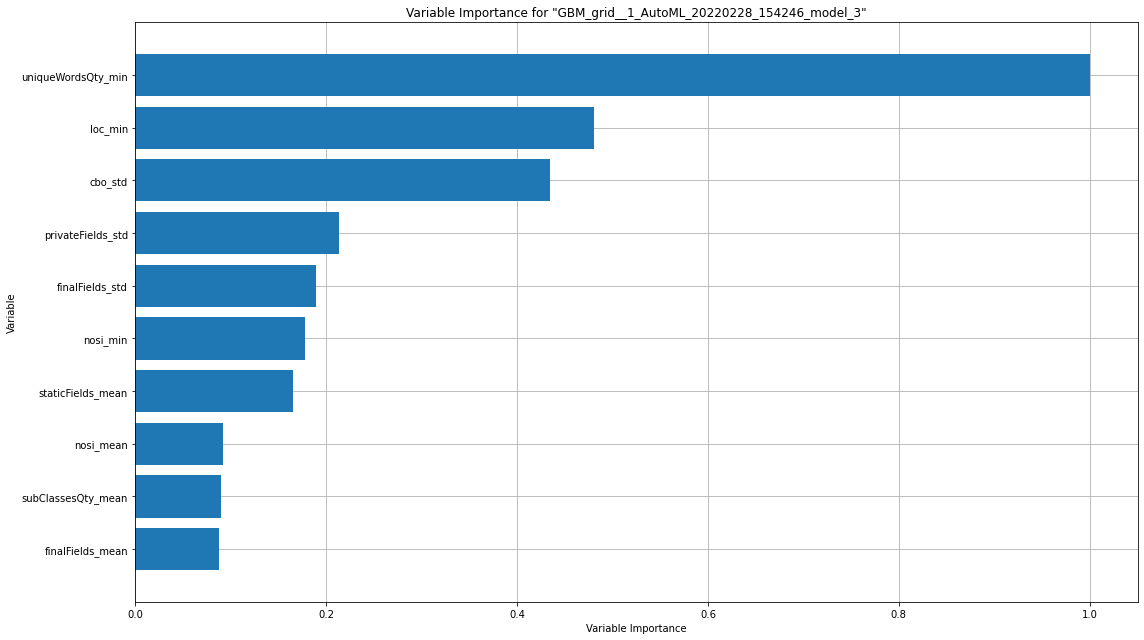

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

C:\ProgramData\Anaconda3\lib\site-packages\h2o\explanation\_explain.py:514: RuntimeWarning: invalid value encountered in true_divide
  res = (res - np.nanmin(res)) / (np.nanmax(res) - np.nanmin(res))


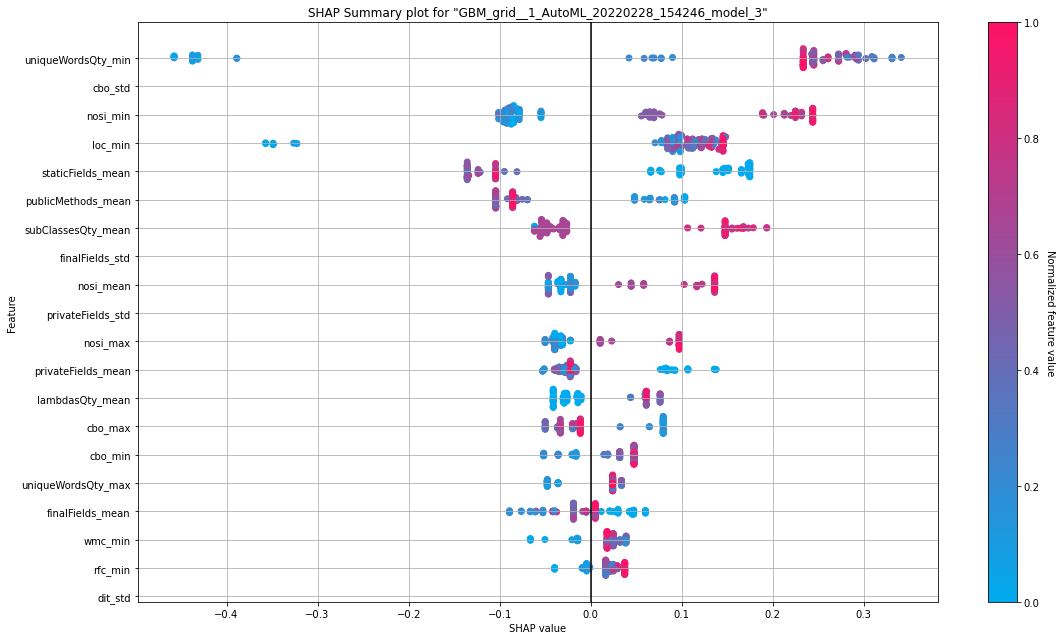

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

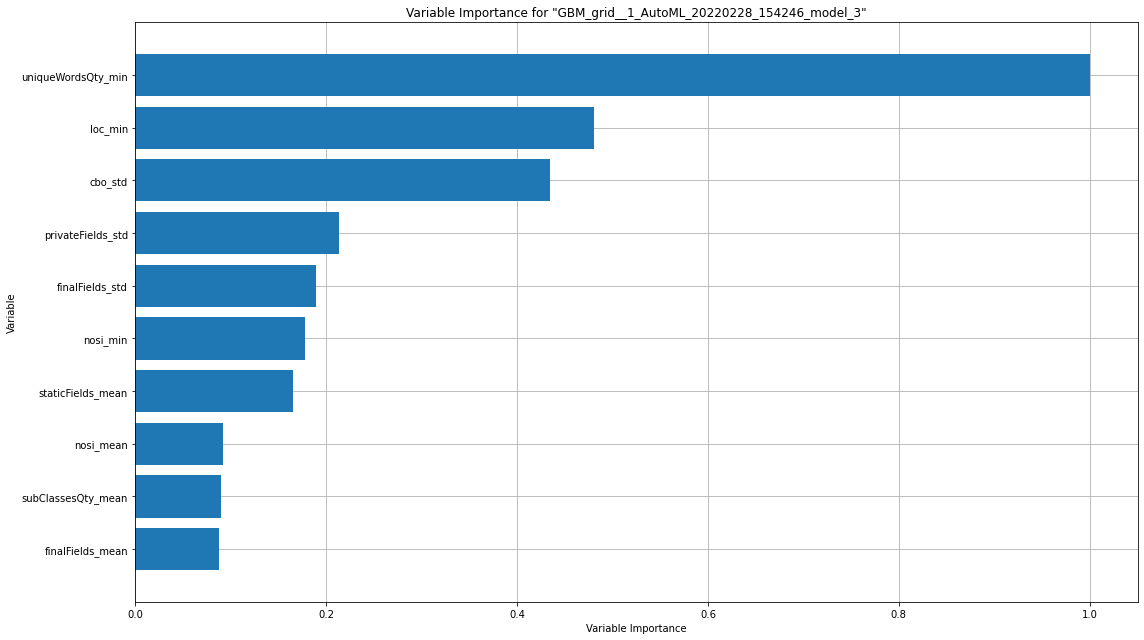

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

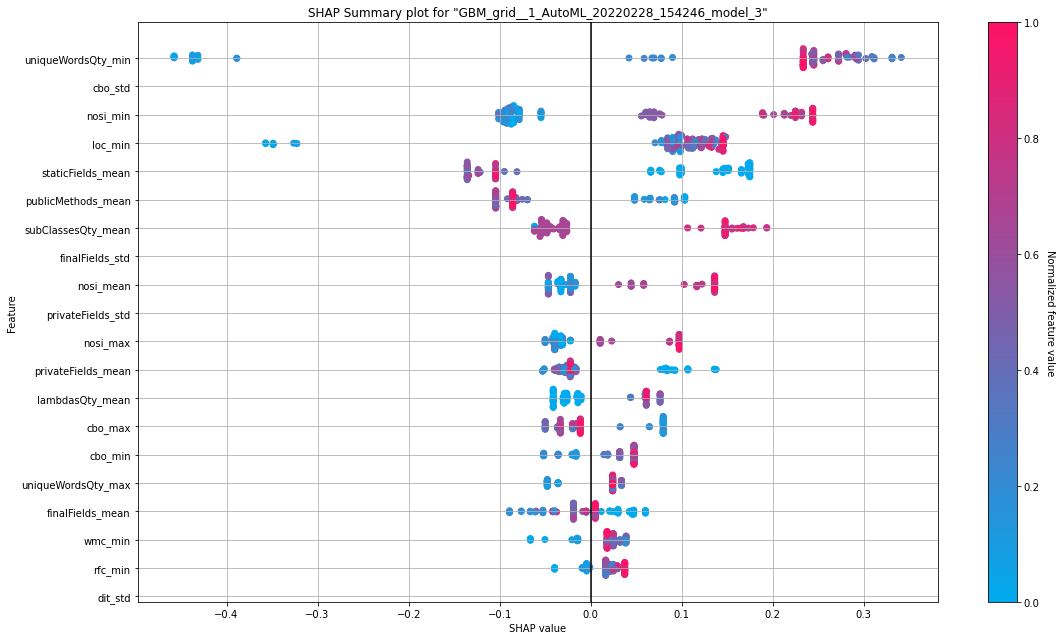

In [171]:
saved_model.explain(prediction_df, include_explanations=["varimp",'shap_summary'])

In [144]:
pd_preds['predicted_time'] = np.exp(pd_preds['predict'])
pd_preds['class_name'] = project_refactoring_data_agg['class_name']
pd_preds['refactor_destination'] = project_refactoring_data_agg['refactor_destination']

In [145]:
print(pd_preds.shape)
pd_preds.head()

(489, 4)


,predict,predicted_time,class_name,refactor_destination
0,0.882921,2.417951,AbstractAppenderFactory.java,185
1,0.273833,1.314995,AbstractAuthResourceConfig.java,184
2,1.553440,4.727706,AbstractDAO.java,0
3,1.304600,3.686213,AbstractDAOTest.java,0
4,0.985475,2.679083,AbstractHttp2Test.java,0


In [146]:
pd_preds.to_csv('pipeline_prediction_output.csv', index=False)

In [147]:
refactor_arr

[['AuthFilter.java', 185],
 ['AuthenticationException.java', 184],
 ['Authenticator.java', 0],
 ['AuthorizationContext.java', 0],
 ['Authorizer.java', 0],
 ['CachingAuthenticator.java', 0],
 ['CachingAuthorizer.java', 0],
 ['JSONUnauthorizedHandler.java', 294],
 ['PermitAllAuthorizer.java', 285],
 ['PrincipalImpl.java', 289],
 ['UnauthorizedHandler.java', 0],
 ['BasicCredentialAuthFilter.java', 227],
 ['BasicCredentials.java', 0],
 ['ChainedAuthFilter.java', 0],
 ['OAuthCredentialAuthFilter.java', 0],
 ['AbstractAuthResourceConfig.java', 0],
 ['AuthBaseTest.java', 0],
 ['AuthFilterTest.java', 0],
 ['CachingAuthenticatorTest.java', 183],
 ['CachingAuthorizerTest.java', 0],
 ['BasicAuthProviderTest.java', 267],
 ['BasicCredentialsTest.java', 0],
 ['BasicCustomAuthProviderTest.java', 0],
 ['ChainedAuthProviderTest.java', 0],
 ['OAuthCustomProviderTest.java', 0],
 ['OAuthProviderTest.java', 0],
 ['JsonPrincipal.java', 0],
 ['NoAuthPolymorphicPrincipalEntityResource.java', 0],
 ['NoAuthPoly

In [148]:
pd_preds.head()

,predict,predicted_time,class_name,refactor_destination
0,0.882921,2.417951,AbstractAppenderFactory.java,185
1,0.273833,1.314995,AbstractAuthResourceConfig.java,184
2,1.553440,4.727706,AbstractDAO.java,0
3,1.304600,3.686213,AbstractDAOTest.java,0
4,0.985475,2.679083,AbstractHttp2Test.java,0


In [149]:
pd_preds['file'] = project_refactoring_data_agg['file']
pd_preds.head()

,predict,predicted_time,class_name,refactor_destination,file
0,0.882921,2.417951,AbstractAppenderFactory.java,185,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
1,0.273833,1.314995,AbstractAuthResourceConfig.java,184,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
2,1.553440,4.727706,AbstractDAO.java,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
3,1.304600,3.686213,AbstractDAOTest.java,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...
4,0.985475,2.679083,AbstractHttp2Test.java,0,dropwizard dropwizard_v2.0.6 dropwizard-auth ...


In [150]:
STOP_WORDS = ['C:', 'Users', 'tanji', 'Desktop', 'Software', 'Remodularization']

In [151]:
def create_token_table(data_hdf, col_name, prefix, sent_sample_rate = 0.0, epochs = 25, vec_size=20):
    # Tokenize
    words = tokenize(data_hdf[col_name])
    w2v_model = H2OWord2vecEstimator(sent_sample_rate = sent_sample_rate, 
                                     epochs = epochs, 
                                     vec_size = vec_size)
    w2v_model.train(training_frame=words)
    
    # Create the training vectors
    vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")
    
    
    # Prefix naming the columns
    vecs.columns = ['%s%s' % (prefix, c) for c in vecs.columns]
    data2_hdf = data_hdf.cbind(vecs)
    return data2_hdf, w2v_model

    
def tokenize(sentences, stop_word = STOP_WORDS):
    STOP_WORDS = ['C:', 'Users', 'tanji', 'Desktop', 'Software', 'Remodularization']
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [152]:
commit_message_df = pd_preds[['file',]]
commit_message_df.shape
commit_message_df.head()
commit_message_hdf = h2o.H2OFrame(commit_message_df, 
                         column_types = {'file': 'string'}
                        )
commit_message_hdf.types

{'file': 'string'}

In [153]:
commit_message_hdf.head()

file
dropwizard dropwizard_v2.0.6 dropwizard-auth src main java io dropwizard auth AuthFilter.java
dropwizard dropwizard_v2.0.6 dropwizard-auth src main java io dropwizard auth AuthenticationException.java
dropwizard dropwizard_v2.0.6 dropwizard-auth src main java io dropwizard auth Authenticator.java
dropwizard dropwizard_v2.0.6 dropwizard-auth src main java io dropwizard auth AuthorizationContext.java
dropwizard dropwizard_v2.0.6 dropwizard-auth src main java io dropwizard auth Authorizer.java
dropwizard dropwizard_v2.0.6 dropwizard-auth src main java io dropwizard auth CachingAuthenticator.java
dropwizard dropwizard_v2.0.6 dropwizard-auth src main java io dropwizard auth CachingAuthorizer.java
dropwizard dropwizard_v2.0.6 dropwizard-auth src main java io dropwizard auth JSONUnauthorizedHandler.java
dropwizard dropwizard_v2.0.6 dropwizard-auth src main java io dropwizard auth PermitAllAuthorizer.java
dropwizard dropwizard_v2.0.6 dropwizard-auth src main java io dropwizard auth PrincipalImpl.java


In [ ]:
commit_message_vecs_hdf, commit_message_w2v_model = create_token_table(commit_message_hdf,
                                                                  'file',
                                                                   prefix='file_',
                                                                   vec_size=30)

In [ ]:
commit_message_vecs_hdf.head()

In [ ]:
commit_message_w2v_model.find_synonyms('refactor')

In [6]:
import difflib
difflib.get_close_matches('appel', ['ape', 'apple', 'peach', 'puppy'])

['apple', 'ape']